In [166]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random

In [179]:
train_x = np.load('train_images.npy', encoding='latin1')
train_x = np.array([arr[1] for arr in train_x], np.uint8)
train_y_list = np.array(pd.read_csv('train_labels.csv', usecols=['Category']))

In [284]:
def find_contours(img_gray):
    ret, thresh = cv2.threshold(img_gray, 127, 255, 0)
    
    thresh_gray = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)
    thresh = thresh_gray.astype('uint8')
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return image, contours

In [304]:
def clean_noise_by_contours(idx):
    img = train_x[idx].reshape(100, 100)
    img_gray = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    image, contours = find_contours(img_gray)
    
    num_contour = len(contours)
    
    max_area = 0
    max_area_idx = 0
    for i in range(0, num_contour):
        contour = contours[i]
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_area_idx = i
    
    for i in range(0, num_contour):
        if i != max_area_idx:
            cv2.drawContours(image, contours, i, -1, 3)
            
    plt.imshow(image)

(100, 100)


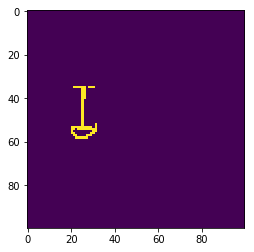

In [305]:
clean_noise_by_contours(0)

In [164]:
def clean_noise():
    idx = random.randint(0, 10000-1)
    # idx = 5215
    print("label:", train_y_list[idx])
    img = np.uint8(train_x[idx].reshape(100, 100))
    gray = cv2.resize(img, (100, 100))
    img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]
    retval, labels = cv2.connectedComponents(img)
    
    num = labels.max()
    N = 28
    for i in range(1, num+1):
        pts = np.where(labels == i)
        if len(pts[0]) < N:
            labels[pts] = 0
    
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[labeled_img == 0] = 0
    
    plt.imshow(labeled_img)
    print("Index of image", idx)
    return (idx, labeled_img)

label: ['apple']
Index of image 7767


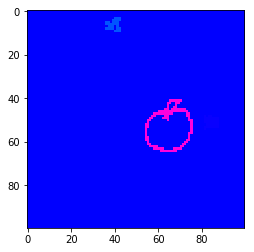

In [165]:
(idx, labeled_img) = clean_noise()

error: OpenCV(3.4.3) c:\projects\opencv-python\opencv\modules\imgproc\src\color.hpp:255: error: (-2:Unspecified error) in function '__cdecl cv::CvtHelper<struct cv::Set<1,-1,-1>,struct cv::Set<3,4,-1>,struct cv::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 3


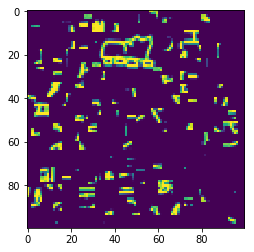

In [161]:
plt.imshow(train_x[idx].reshape(100, 100))

gray = cv2.cvtColor(labeled_img, cv2.COLOR_GRAY2BGR)

(100, 100, 3)


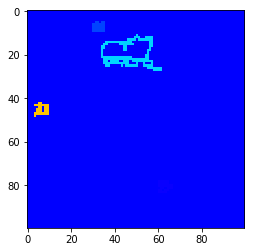

In [163]:
image_data = np.asarray(labeled_img)
image_data_bw = image_data.max(axis=2)
non_empty_columns = np.where(image_data_bw.max(axis=0)>0)[0]
non_empty_rows = np.where(image_data_bw.max(axis=1)>0)[0]
cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))

image_data_new = image_data[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 , :]
# image_data_new = image_data_new.astype('int8')
print(image_data_new.shape)

plt.imshow(image_data_new)

In [109]:
class image:
    def __init__(self, raw):
        self.raw = raw
        # self.img is a cv2 array
        self.img = self.raw.reshape(100, 100)
        # grayscaled image
        self.grayscaled_img = cv2.cvtColor(self.img, cv2.COLOR_GRAY2BGR)
        # resize grayscaled image
        self.gray = cv2.resize(self.grayscaled_img, (100, 100))
        # grayscaled image after max pooling
        self.resized_img = None
        
    def show(self, img):
        plt.imshow(img)

    def clean_noise(self):
        img = self.gray
        ret, threshold = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
        im2, contours, hierarchy = cv2.findContours(threshold, cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_NONE)
        self.show(im2)
        return contours
        
                
    # A technique to reduce the dimensions of an image by taking the maximum pixel value of a grid. 
    # This also helps reduce over-fitting and makes the model more generic. 
    def max_pooling(self, side_len):
        slice_x = 100/side_len
        slice_y = slice_x
        res = np.zeros((slice_x, slice_y))
        for i in range(0, slice_x):
            for j in range(0, slice_y):
                max = 0
                for p in range(i*side_len, (i+1)*side_len):
                    for q in range(j*side_len, (j+1)*side_len):
                        val = self.grayscaled_img[p][q]
                        if val>max: 
                            max = val
                res[i][j] = max
        self.resized_img = res
        return res

ValueError: too many values to unpack (expected 2)

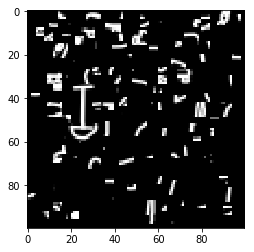

In [39]:
img = image(train_x[0])
img.show(img.grayscaled_img)
img.clean_noise()